In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import copy

import numpy as np
import math
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
import pandas as pd
import prophet
import yfinance as yf
from scipy.optimize import brentq, fsolve

import pyvinecopulib as pv

Importing plotly failed. Interactive plots will not work.


### Sklar's Theorem

$$ H(x_1, x_2, ... x_d) = C(F_1(x_1), F_2(x_2) ... F_d(x_d)) $$
$$ C(u_1,u_2, ... u_d) = H(F_1^{-1}(u_1), F_2^{-1}(u_2) ... F_d^{-1}(u_d)) $$

### 2-D parametrization of joint density
$$ 
\begin{align}
    f(x_1, x_2) &= f(x_1 | x_2) f(x_2) \\
                &= f(x_2 | x_1) f(x_1) 
\end{align}
$$

### 3-D parametrization of joint density

$$ 
\begin{align}
    f(x_1, x_2, x_3) &= f_{1|2,3}(x_1|x_2,x_3) f_{2|3}(x_2|x_3)f_3(x_3) \\
                     &= f_{1|2,3}(x_1|x_2,x_3) f_{3|2}(x_3|x_2)f_2(x_2) \\
                     &= f_{2|1,3}(x_2|x_1,x_3) f_{1|3}(x_1|x_3)f_3(x_3) \\
                     &= f_{2|1,3}(x_2|x_1,x_3) f_{3|1}(x_3|x_1)f_1(x_1) \\
                     &= f_{3|1,2}(x_3|x_1,x_2) f_{1|2}(x_1|x_2)f_2(x_2) \\
                     &= f_{3|1,2}(x_3|x_1,x_2) f_{2|1}(x_2|x_1)f_1(x_1) \\
\end{align}
$$

### Relationship between conditional density and copula
$$ f_{1|2}{x_1|x_2} = \frac{f(x_1,x_2)}{f_2(x_2)} = c_{1,2}(F_1(x_1), F_2(x_2))f_1(x_1) $$
$$ f_{1|2,3}(x_1|x_2, x_3) = \frac{f(x_1,x_2|x_3)}{f_{2|3}(x_2|x_3)} = c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3))f_{1|3}(x_1|x_3) $$

### Create a Vine Copula

$$ 
\begin{align}
    f(x_1,x_2,x_3) &= f_{1|2,3}(x_1|x_2,x_3) f_{2|3}(x_2|x_3)f_3(x_3) \\ 
                   &= [c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3))f_{1|3}(x_1|x_3)] \times [c_{2,3}(F_2(x_2), F_3(x_3))f_2(x_2)] \times [f_3(x_3)] \\
                   &= [c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3))c_{1,3}(F_1(x_1), F_3(x_3))f_1(x_1)] \times [c_{2,3}(F_2(x_2), F_3(x_3))f_2(x_2)] \times [f_3(x_3)] \\
                   &= f_1(x_1)f_2(x_2)f_3(x_3) \\ & \times c_{1,3}(F_1(x_1),F_3(x_3)) \times c_{2,3}(F_2(x_2),F_3(x_3)) \\ & \times c_{1,2|3}(F_{1|3}(x_1|x_3), F_{2|3}(x_2|x_3))
\end{align}
$$

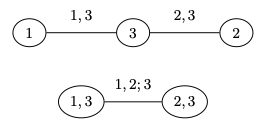

In [3]:
display.Image("vine_example.png")

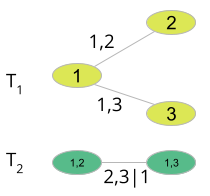

In [4]:
display.Image("cvine_3vars.png")

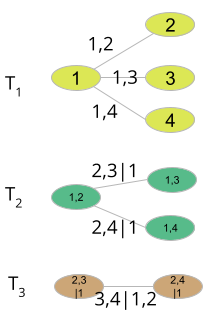

In [5]:
display.Image("cvine_4vars.png")

## Vine Copula Example - Crypto Currencies

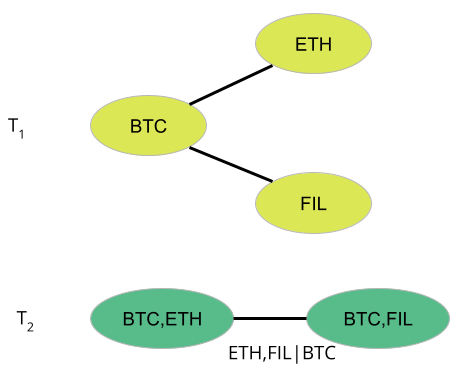

In [6]:
display.Image("crypto_vine_example.png")

In [7]:
tickers = ['BTC-USD', 'ETH-USD', 'FIL-USD']
data = yf.download(' '.join(tickers), start="2021-01-01", end="2023-12-31")

[*********************100%***********************]  3 of 3 completed


<IPython.core.display.Javascript object>


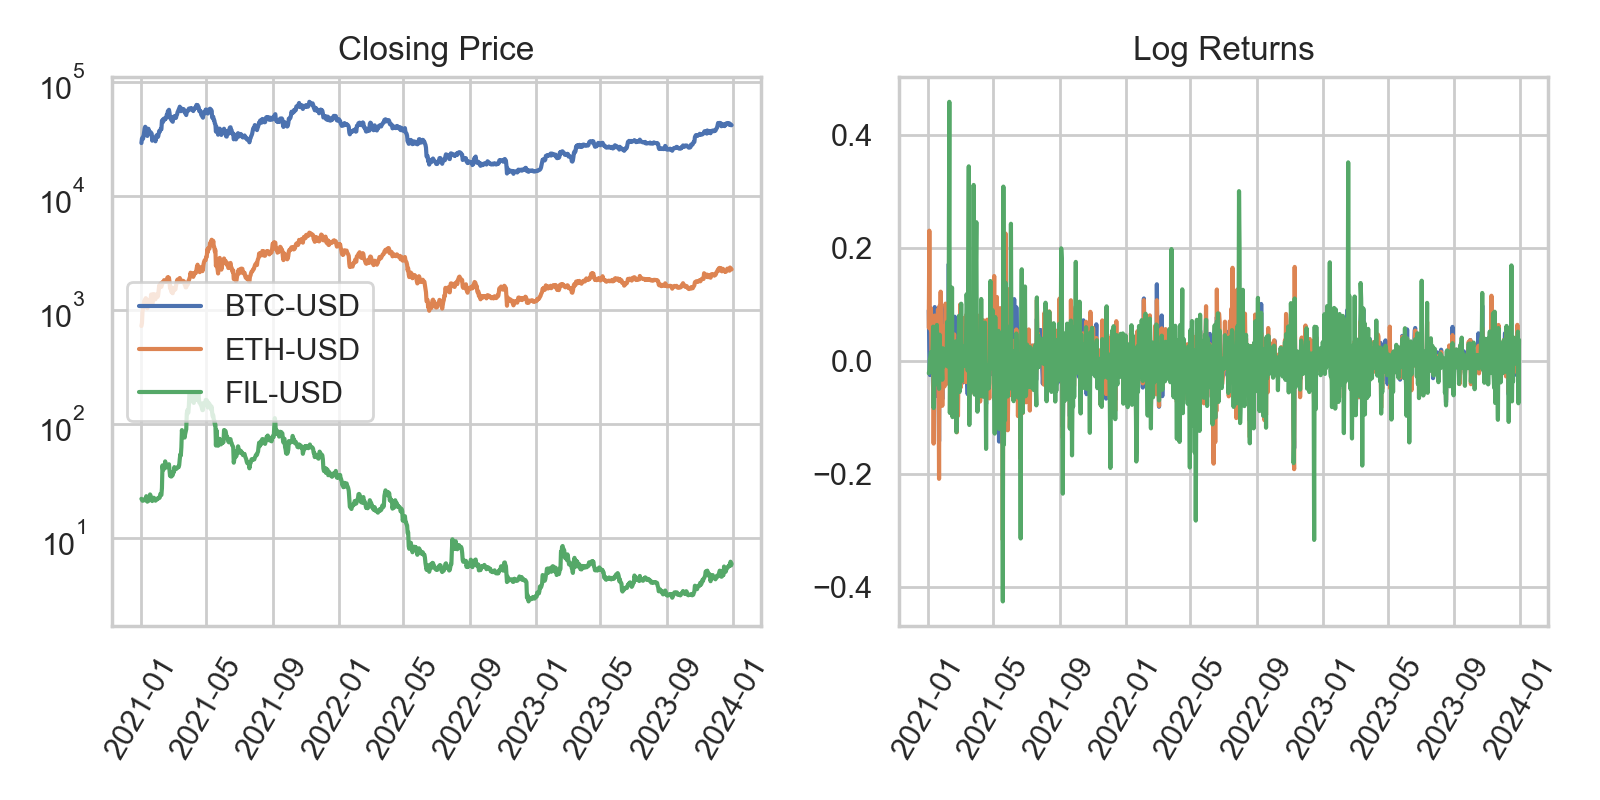

In [8]:
close_prices = data['Adj Close']
# compute log returns
returns_data = np.log1p(close_prices.pct_change())
returns_data = returns_data.reset_index().rename(columns={'Date': 'ds'})
returns_data['ds'] = pd.to_datetime(returns_data['ds']).dt.tz_localize(None)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
for tick in tickers:
    plt.plot(close_prices[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Closing Price')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
for tick in tickers:
    plt.plot(returns_data['ds'], returns_data[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Log Returns')

plt.tight_layout()

In [9]:
tick2data = {}
tick2model = {}
for tick in tickers:
    m = prophet.Prophet()
    df = returns_data[['ds', tick]].rename(columns={tick: 'y'})
    m.fit(df)
    
    # compute residuals
    df_forecast = m.predict()
    df = pd.merge(df, df_forecast, on='ds')
    df['residual'] = df['y'] - df['yhat']

    tick2data[tick] = df
    tick2model[tick] = m

08:42:15 - cmdstanpy - INFO - Chain [1] start processing
08:42:15 - cmdstanpy - INFO - Chain [1] done processing
08:42:16 - cmdstanpy - INFO - Chain [1] start processing
08:42:16 - cmdstanpy - INFO - Chain [1] done processing
08:42:16 - cmdstanpy - INFO - Chain [1] start processing
08:42:16 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>


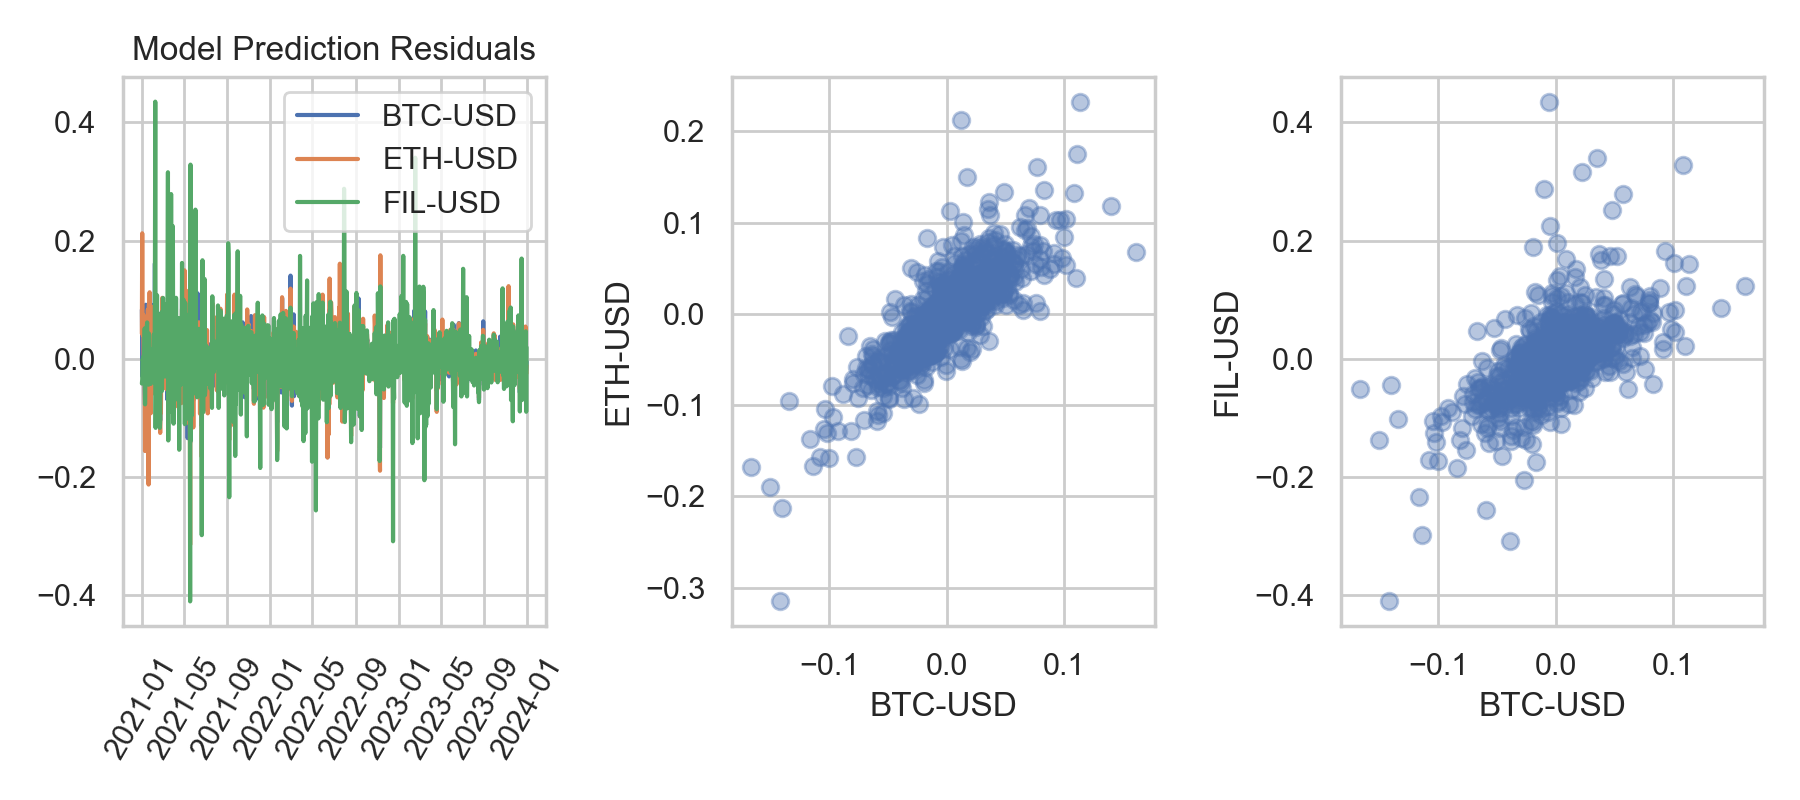

In [10]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
for tick in tickers:
    df = tick2data[tick]
    plt.plot(df['ds'], df['residual'], label=tick)
plt.xticks(rotation=60)
plt.legend()
plt.title('Model Prediction Residuals')

center_tick = 'BTC-USD'
remaining_tickers = copy.copy(tickers)
remaining_tickers.remove(center_tick)

plt.subplot(1,3,2)
t = 'ETH-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data[t]['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel(t)

plt.subplot(1,3,3)
t = 'FIL-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data[t]['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel(t)

plt.tight_layout()

In [11]:
X = pd.DataFrame()
X['btc_residual'] = tick2data['BTC-USD']['residual'] 
X['eth_residual'] = tick2data['ETH-USD']['residual'] 
X['fil_residual'] = tick2data['FIL-USD']['residual']
U = pv.to_pseudo_obs(X)

<IPython.core.display.Javascript object>


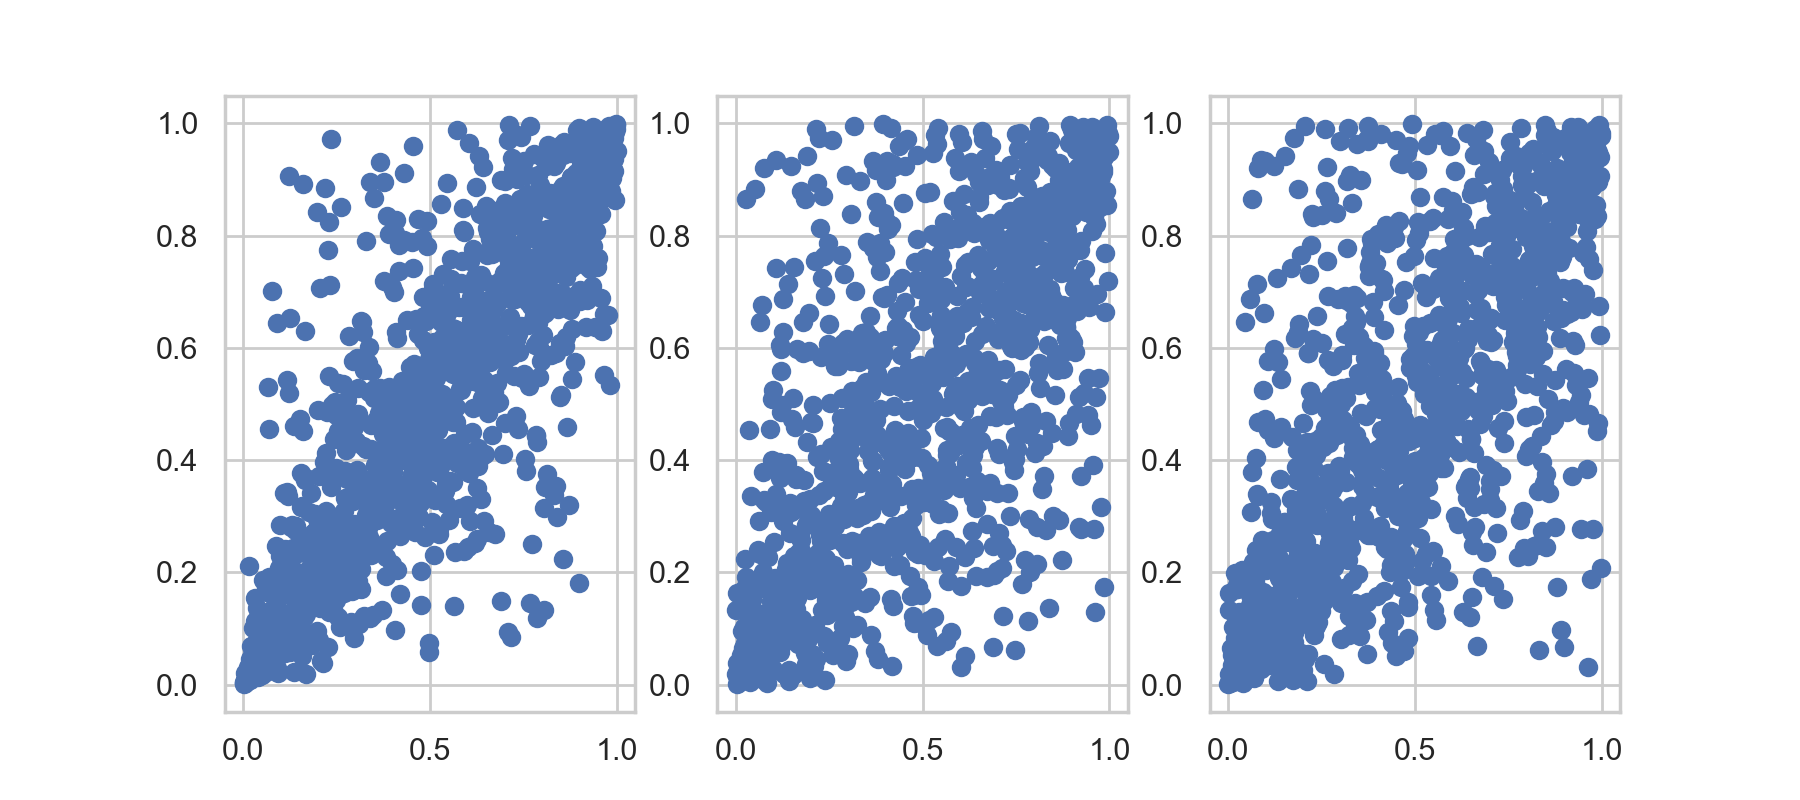

In [12]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.scatter(U[:,0], U[:,1])

plt.subplot(1,3,2)
plt.scatter(U[:,0], U[:,2])

plt.subplot(1,3,3)
plt.scatter(U[:,1], U[:,2])

In [13]:
cop = pv.Vinecop(data=U, 
                 structure = pv.CVineStructure([3,2,1]))

In [14]:
cop

<pyvinecopulib.Vinecop>
** Tree: 0
3,1 <-> TLL, parameters = [30x30 grid]
2,1 <-> TLL, parameters = [30x30 grid]
** Tree: 1
3,2 | 1 <-> TLL, parameters = [30x30 grid]

In [15]:
n_sim = 500
u_sim = cop.simulate(n_sim, seeds=[1, 2, 3])
x = X.values
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(0, 3)])

<IPython.core.display.Javascript object>


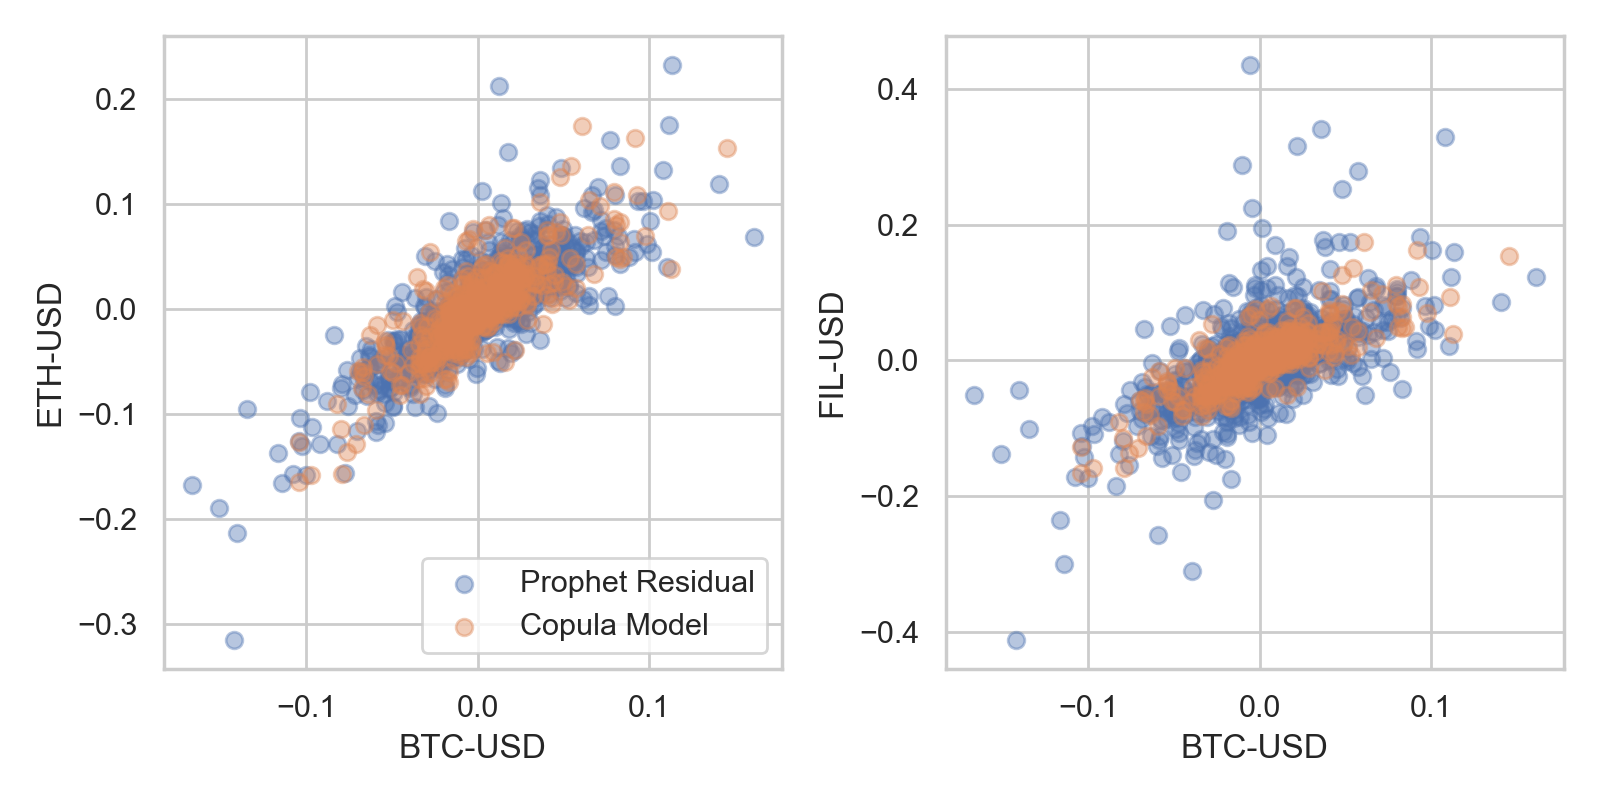

In [16]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
t = 'ETH-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data['ETH-USD']['residual'], alpha=0.4, label='Prophet Residual')
plt.scatter(x_sim[0,:], x_sim[1,:], alpha=0.4, label='Copula Model')
plt.xlabel(center_tick)
plt.ylabel(t)
plt.legend()

plt.subplot(1,2,2)
t = 'FIL-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data['FIL-USD']['residual'], alpha=0.4)
plt.scatter(x_sim[0,:], x_sim[1,:], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel(t)

plt.tight_layout()